In [14]:
%matplotlib notebook
# Base imports
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

# pilatus roi imports
import pilroi
from pilroi.plotting import animate_scan

# Importing data
Define the path to a scan .csv and the corresponding folder in which the detector images are saved.  Also define the attenuation of the foils as a list

In [15]:
csv_path = './data/BL72/IC41_00L_data_scan3_scan1.csv'
im_folder = './data/BL72/IC41_00L_images_scan3/'
# Uncomment below to look at NA03 instead of IC41
#csv_path = '/Users/nolan/Documents/research/Data/SSRL/Feb2019_72/NA03/NA03_00L_data_scan1.csv'
#im_folder = '/Users/nolan/Documents/research/Data/SSRL/Feb2019_72/NA03/NA03_00L_images/'


# Foils defined as a list of four floats
foils = [0.890, 2.524, 3.830, 10.871]

# Import scan file.  For now, ignore the cen=() kwarg
scan = pilroi.data.create_scan(csv_path, im_folder, foils, bl='72')
# Import csv for comparison
csv = pilroi.data.read_scan_csv(csv_path)

# Cropping the images
Adjust window until it encompasses the signal region.  The cropping function also applies the proper filter normalization to the pilatus detector image.

The figure shown is all of the pilatus data squished along the vertical axes, the higher intensity plateau is the region defined by the detector slits, and contains all of the detector signal.  The high intensity peak in the middle is assumed to be the location of the 00L rods

<IPython.core.display.Javascript object>


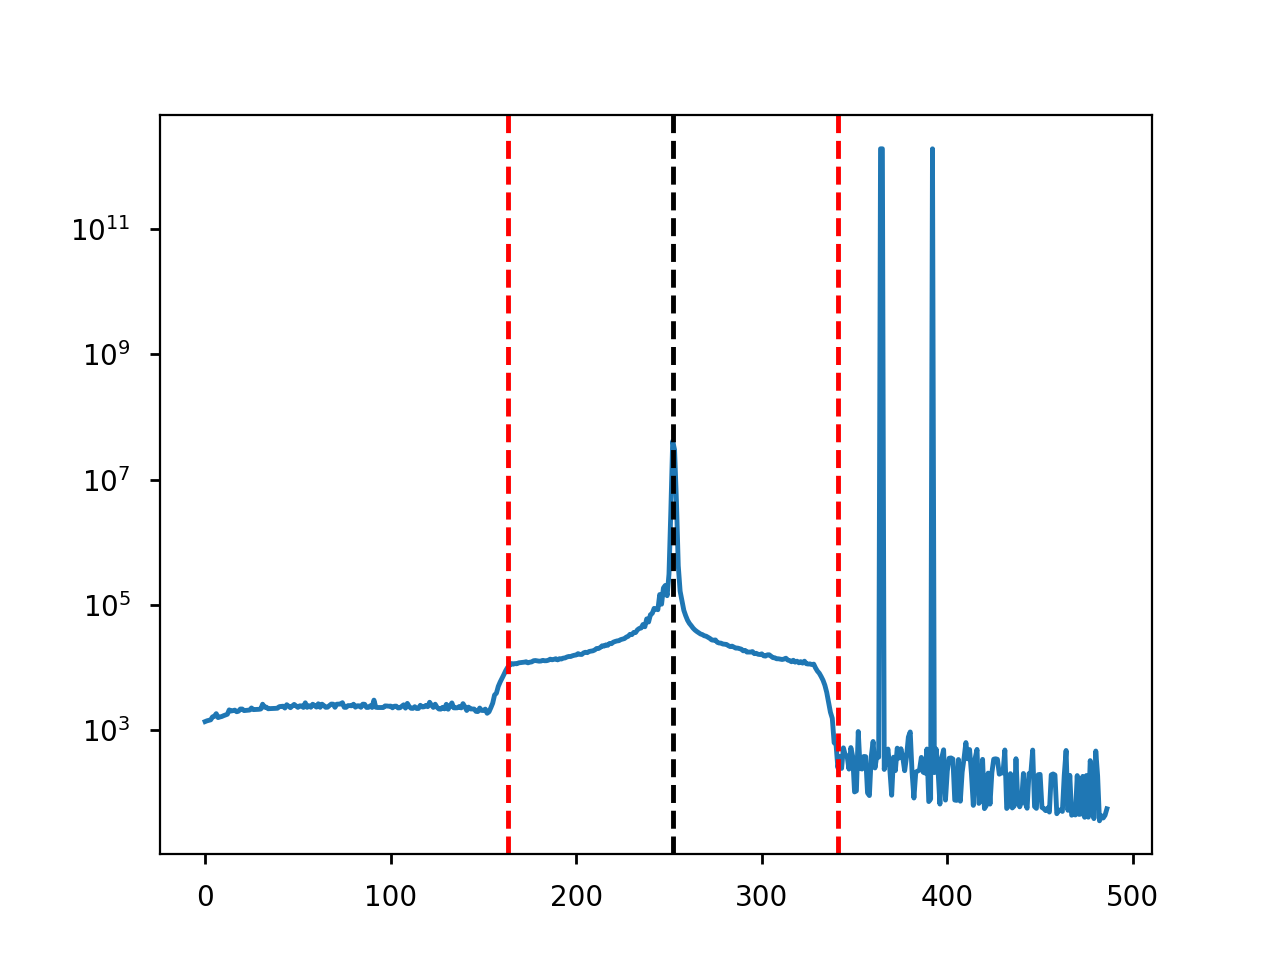

In [16]:
# Define window size
window = 178

# Crop the image
lim1, lim2 = pilroi.data.find_limits(scan, window, center=252)
pilroi.data.crop_scan(scan, lim1, lim2)

# Animate the scan

The red dot in the animation below is the location of the most intense pixel for the given frame.  Axes are currently pixel coordinates

<IPython.core.display.Javascript object>


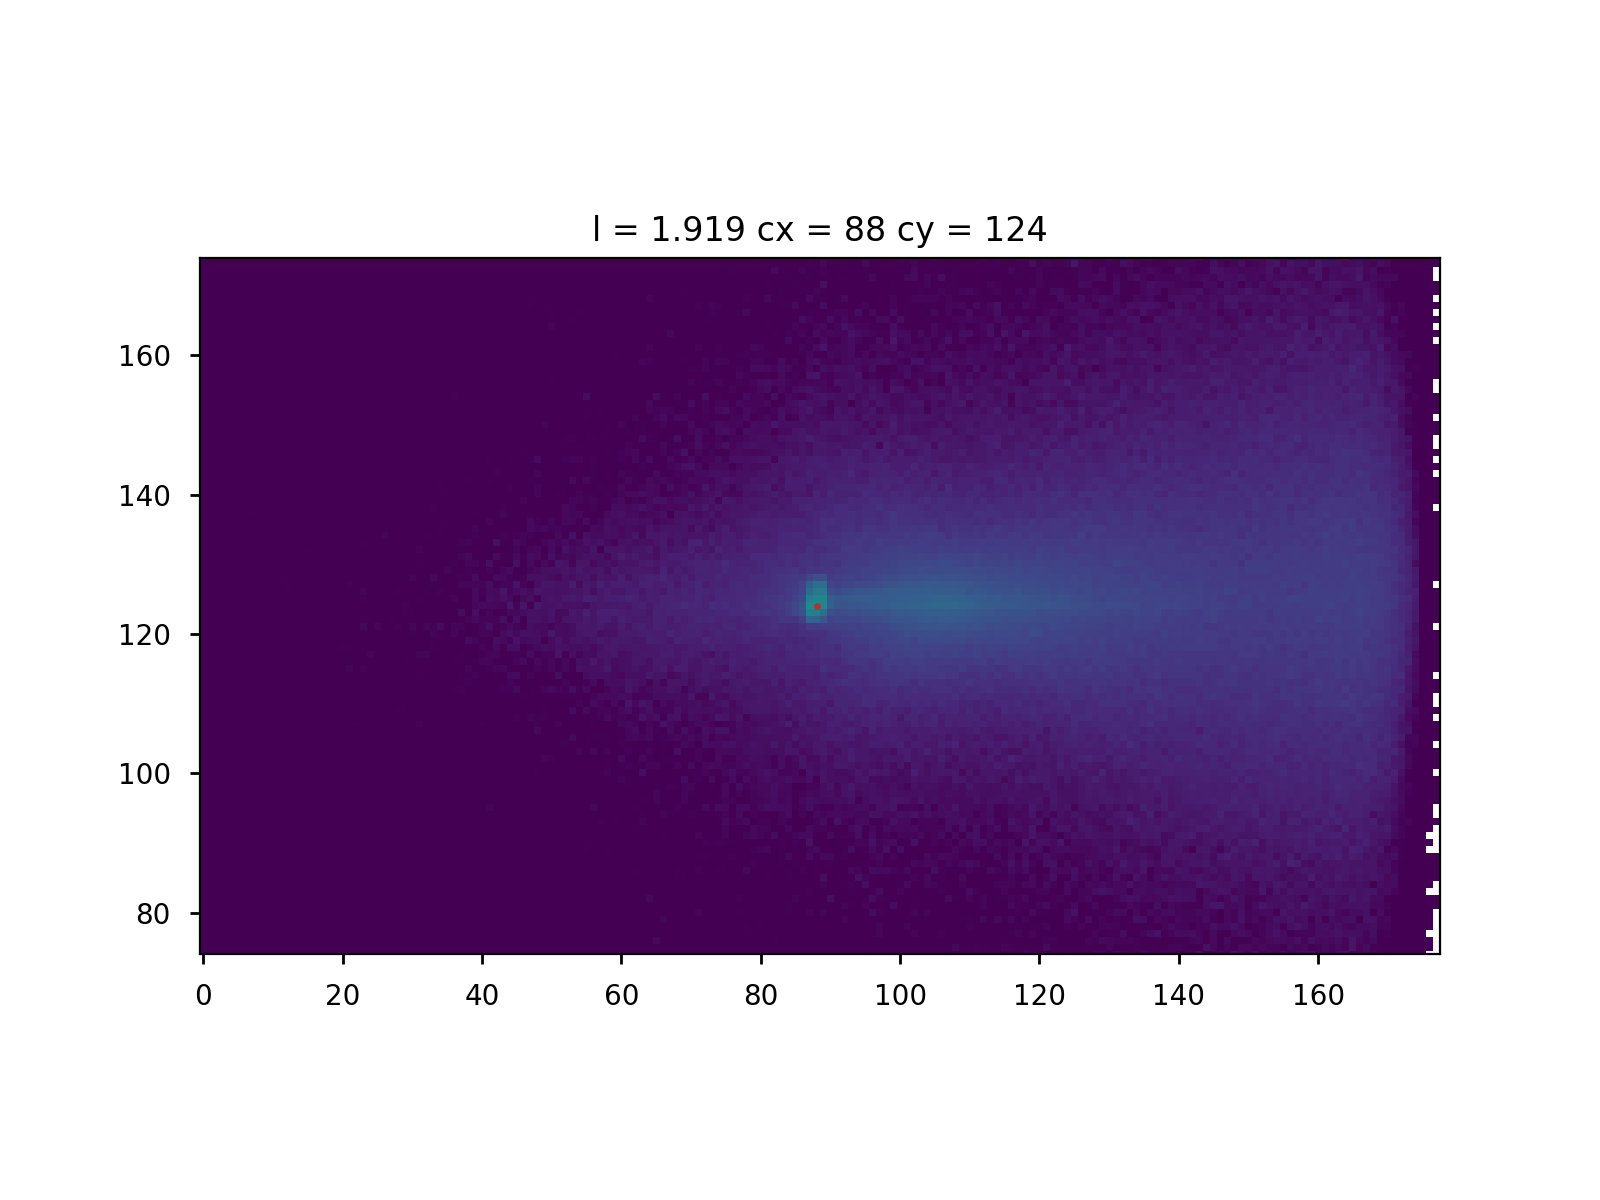

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='l', max=4.1999997, min=0.39…

In [18]:
animate_scan(scan, 'l', vmin=1e2, vmax=1e7, cmap='viridis')

# Defining ROI

ROIs can be made in reference to a signal pixel location using `make_roi()` or they can track the most intense pixel using `roi_track_cen()`

<IPython.core.display.Javascript object>


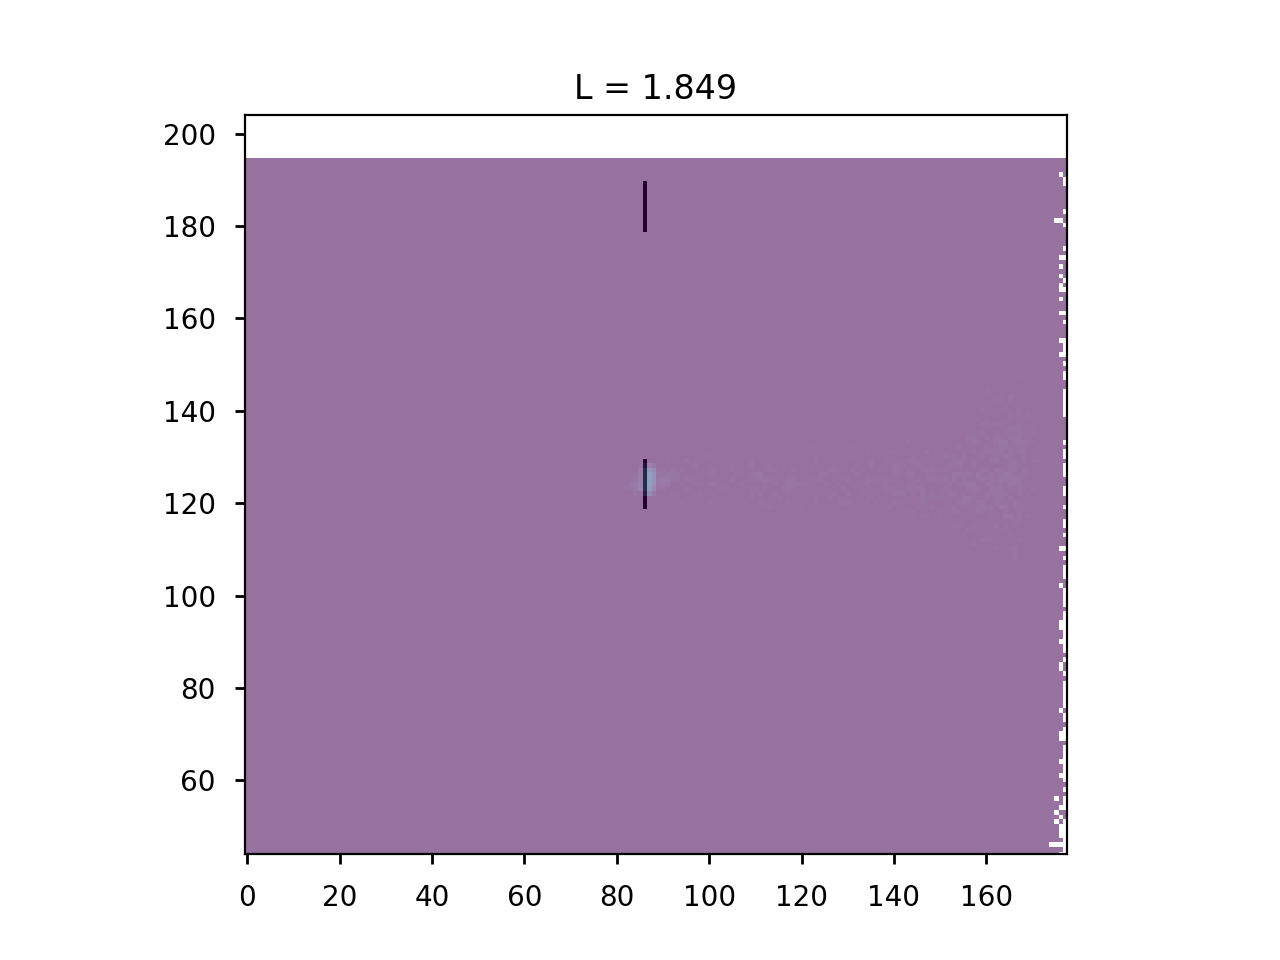

In [19]:
# Define the median intensity pixel, this is used as the stationary "center" location for ROIs
cenx, ceny = scan[['px_x', 'px_y']].median(axis=0)
cenx = int(cenx)
ceny = int(ceny)

# Width, height of ROI.  Offset for background ROI
width = 1
height = 11
offset = 60

# Create static ROI
roi = pilroi.roi.make_roi(scan['crop'][0].shape, cenx, ceny, height, width)
bkgrd = pilroi.roi.make_roi(scan['crop'][0].shape, cenx, ceny + 65, height, width)
# Create tracking ROI

roi_track = pilroi.roi.roi_track_cen(scan, ceny, height, width)
bkgrd_track = pilroi.roi.roi_track_cen(scan, ceny + offset, height, width)

# Plot a given ROI.  Currently plotting the ROI which tracks center pixel motion
idx = pilroi.roi.get_idx(scan, 'l', 1.85)

pilroi.plotting.show_image(scan, idx, ywidth=80)

plt.imshow(roi_track[idx] + bkgrd_track[idx], cmap='binary', alpha=.45)

# Plotting signal from custom ROI
Unfinished - make simpler

Issues: When signal and background are ~ the same, a semilogy plot will have massive jumps b/c signal - background is roughly 0

In [20]:
# Extract signal for many different width ROIs
# Define the median intensity pixel, this is used as the stationary "center" location for ROIs
cenx, ceny = scan[['px_x', 'px_y']].median(axis=0)
cenx = int(cenx)
ceny = int(ceny)

# Width, height of ROI.  Offset for background ROI
width = 1
height = 11
offset = 60


widths = [1, 3, 5, 7, 11, 13, 21]

roi = {}
back = {}

roi_track = {}
back_track = {}

for width in widths:
    roi[width] = pilroi.roi.make_roi(scan['crop'][0].shape, cenx, ceny, height, width)
    back[width] = pilroi.roi.make_roi(scan['crop'][0].shape, cenx, ceny + offset, height, width)
    
    roi_track[width] = pilroi.roi.roi_track_cen(scan, ceny, height, width)
    back_track[width] = pilroi.roi.roi_track_cen(scan, ceny + offset, height, width)
    
    
sig = {}
bkg = {}
sig_track = {}
bkg_track = {}
for width in widths:
    sig[width] = pilroi.roi.roi_extract(scan, roi[width])
    bkg[width] = pilroi.roi.roi_extract(scan, back[width])
    
    sig_track[width] = pilroi.roi.roi_extract(scan, roi_track[width])
    back_track[width] = pilroi.roi.roi_extract(scan, back_track[width])

# Stationary ROI plots

## Compare to normlz

<IPython.core.display.Javascript object>


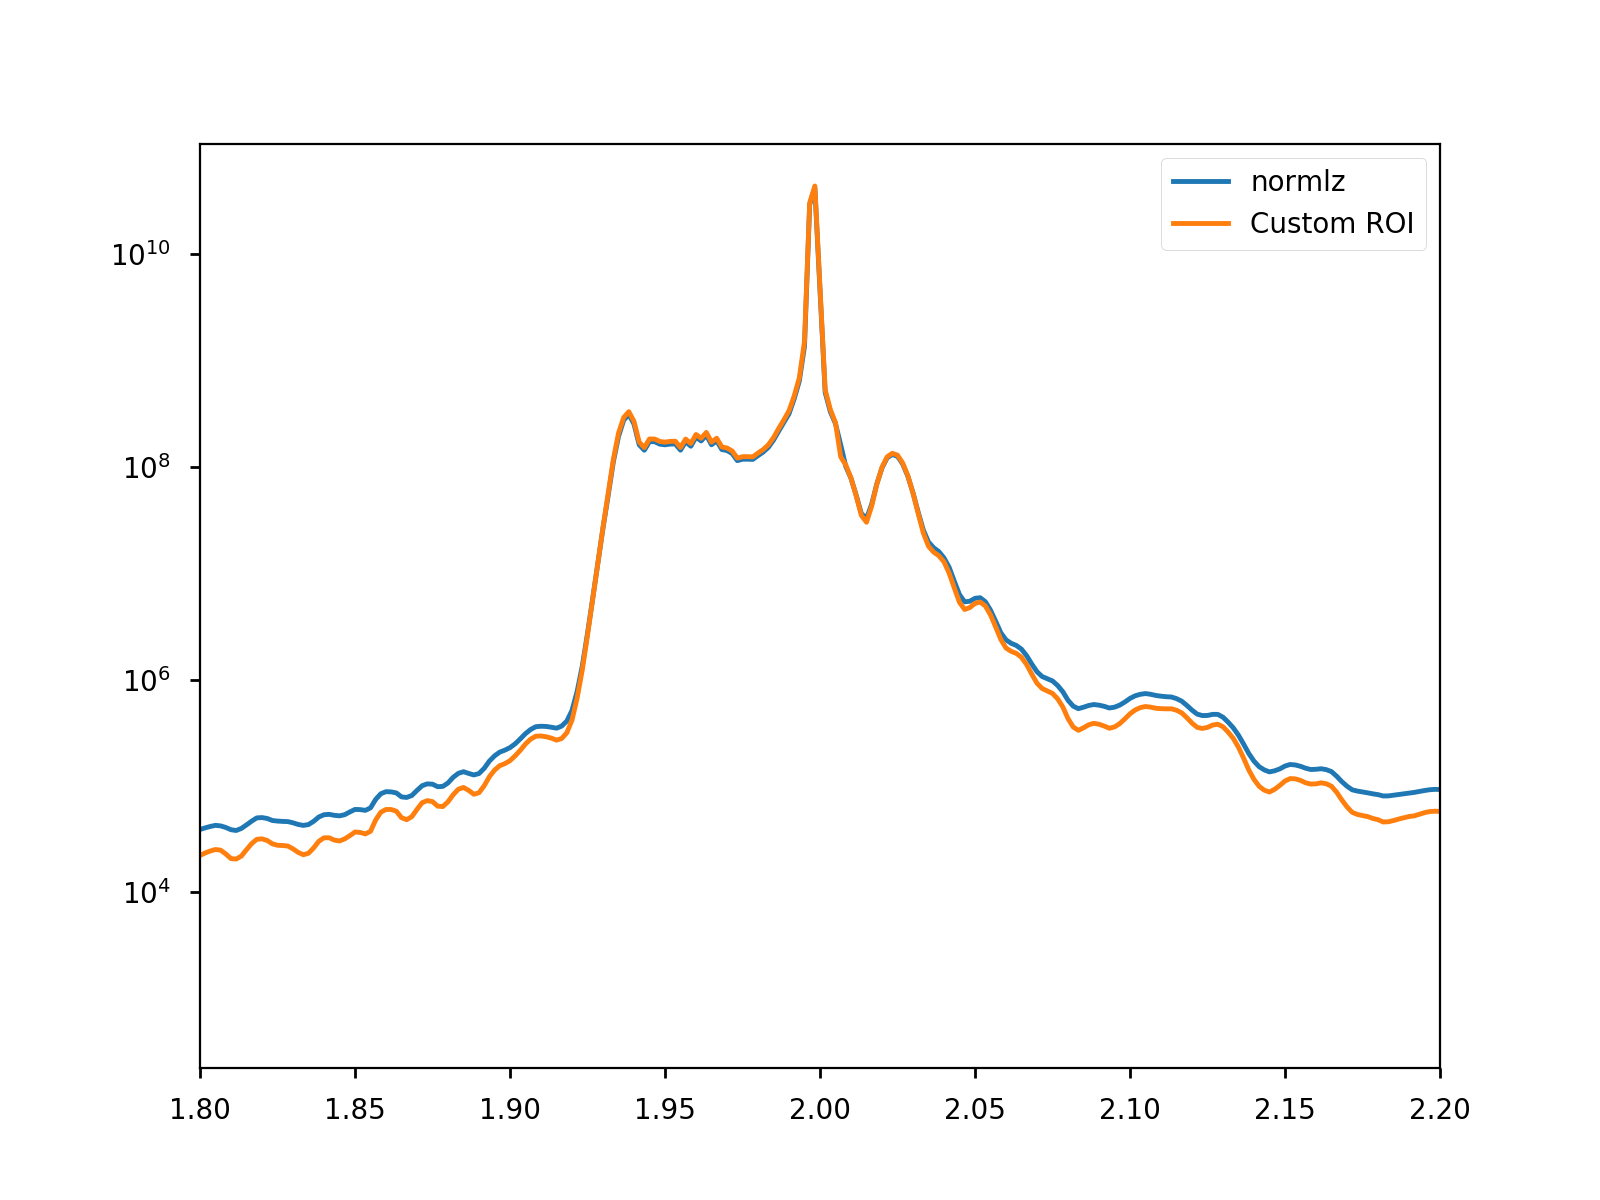

In [21]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.semilogy(csv['l'], csv['normlz'], label='normlz')

w = 21

ax.semilogy(scan['l'], sig[w] - bkg[w], label='Custom ROI')

ax.set_xlim(left=1.8, right=2.2)

ax.legend()

## raw signal and background

<IPython.core.display.Javascript object>


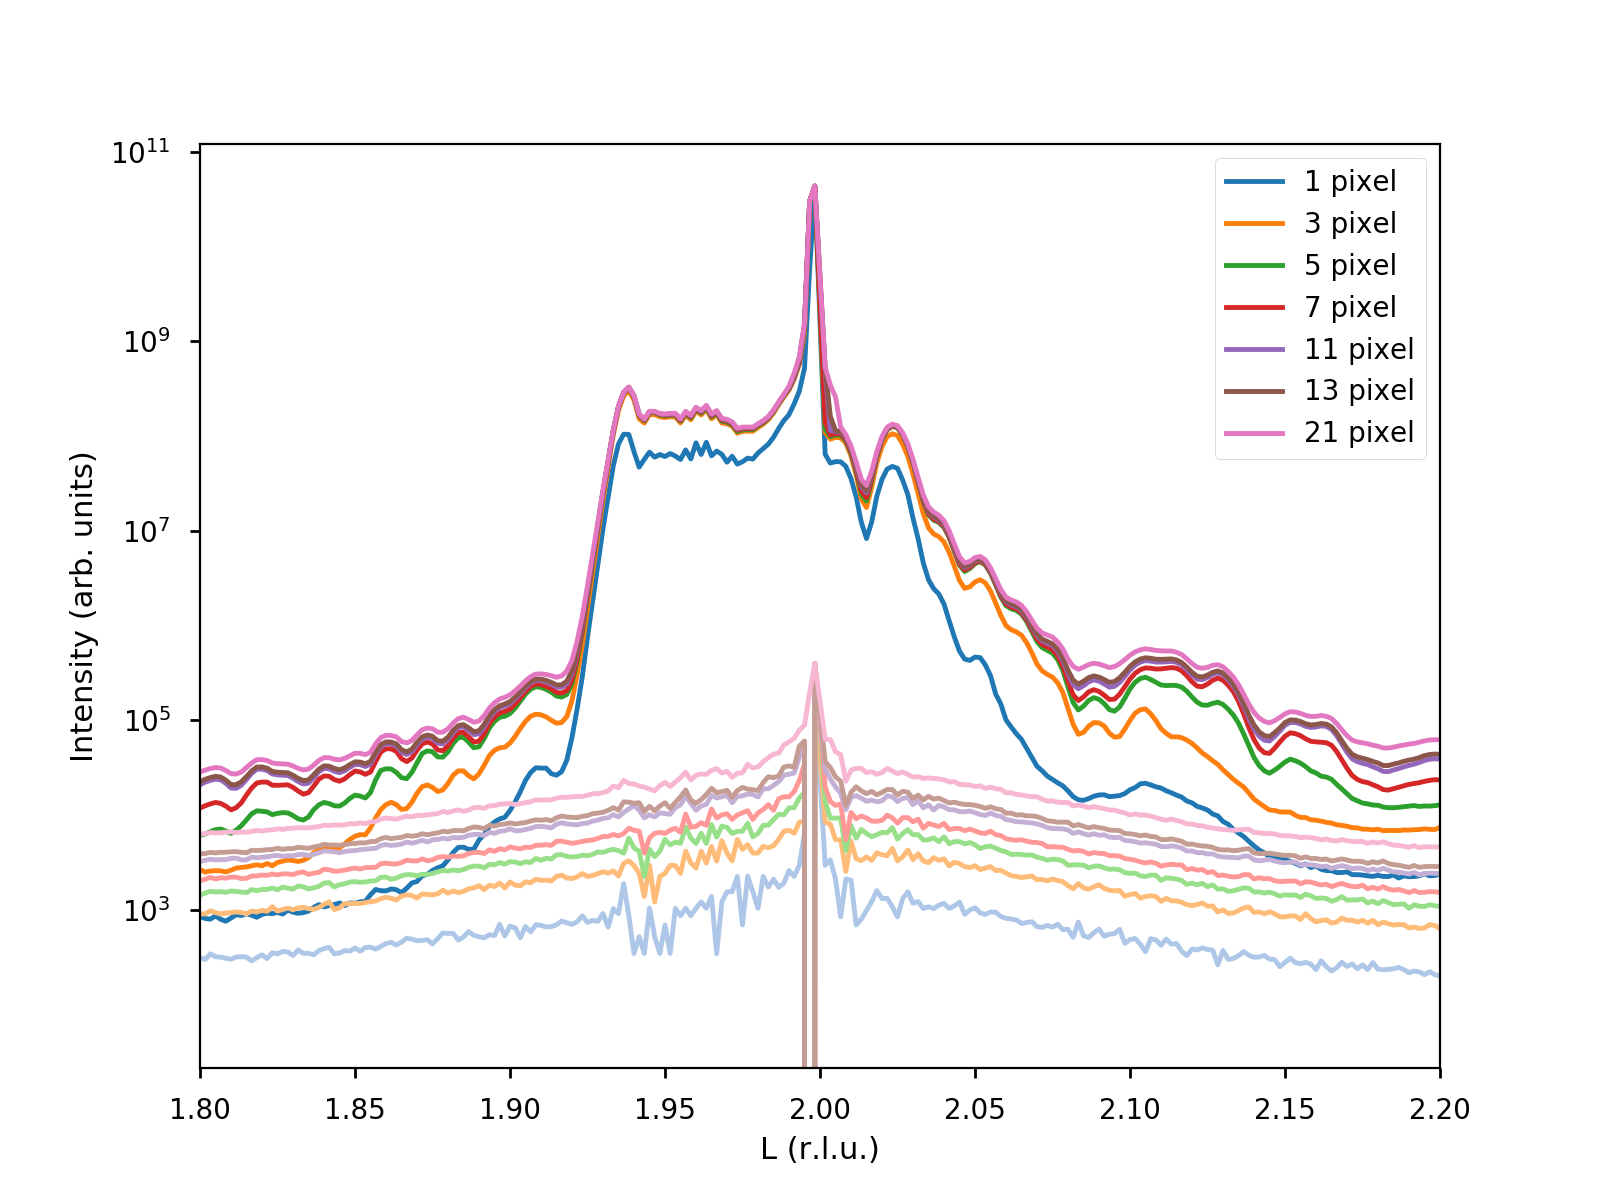

Text(0, 0.5, 'Intensity (arb. units)')

In [22]:
plt.style.use('seaborn-notebook')

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_prop_cycle(cycler(color=plt.get_cmap('tab20').colors))


for width in widths:
    ax.semilogy(scan['l'], sig[width], label=str(width) + ' pixel') 
    ax.semilogy(scan['l'], bkg[width], label='_nolegend_')
    
ax.set_xlim(left=1.8, right=2.2)

ax.legend()

ax.set_xlabel('L (r.l.u.)')
ax.set_ylabel('Intensity (arb. units)')

Signal - background for **stationary ROI**

## signal - background

<IPython.core.display.Javascript object>


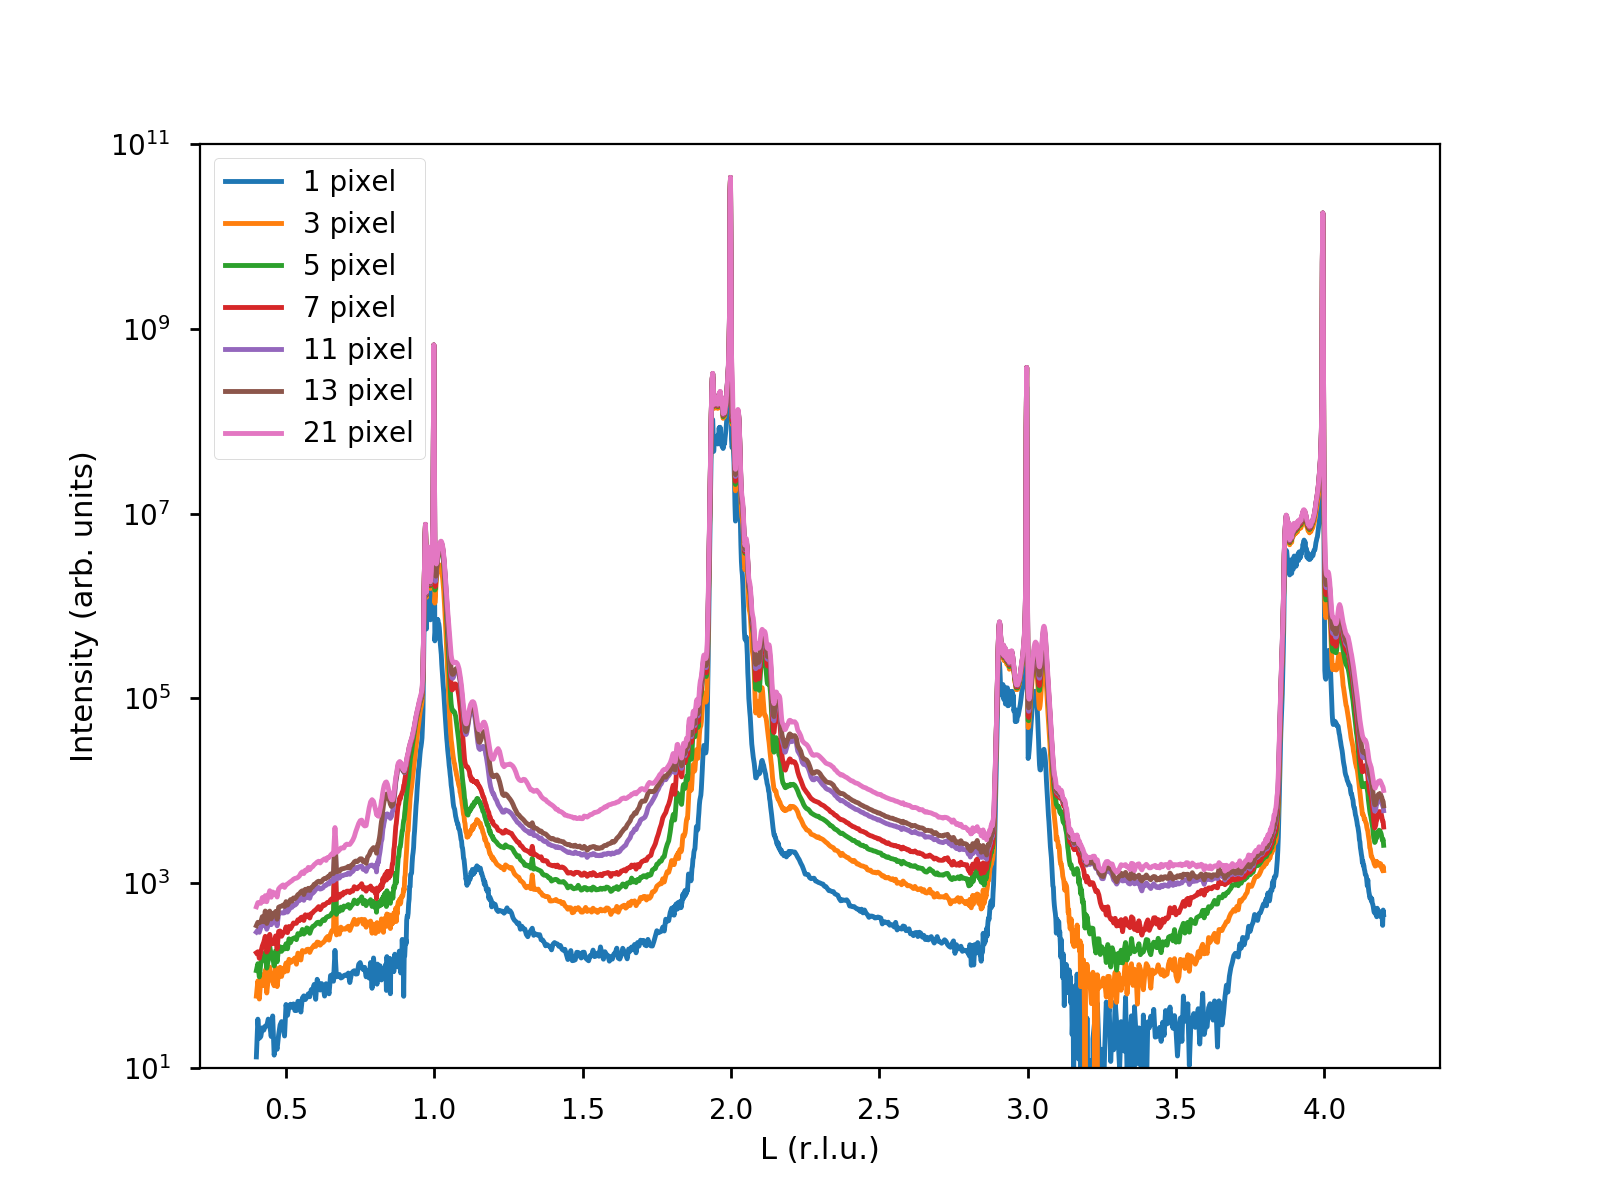

(10.0, 100000000000.0)

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
for width in widths:
    ax.semilogy(scan['l'], sig[width] - bkg[width], label=str(width) + ' pixel')
    
ax.set_xlabel('L (r.l.u.)')
ax.set_ylabel('Intensity (arb. units)')

#ax.set_xlim(left=1.8, right=2.2)
ax.legend()

ax.set_ylim(bottom=1e1, top=1e11)

Motion of central pixel during scans

<IPython.core.display.Javascript object>


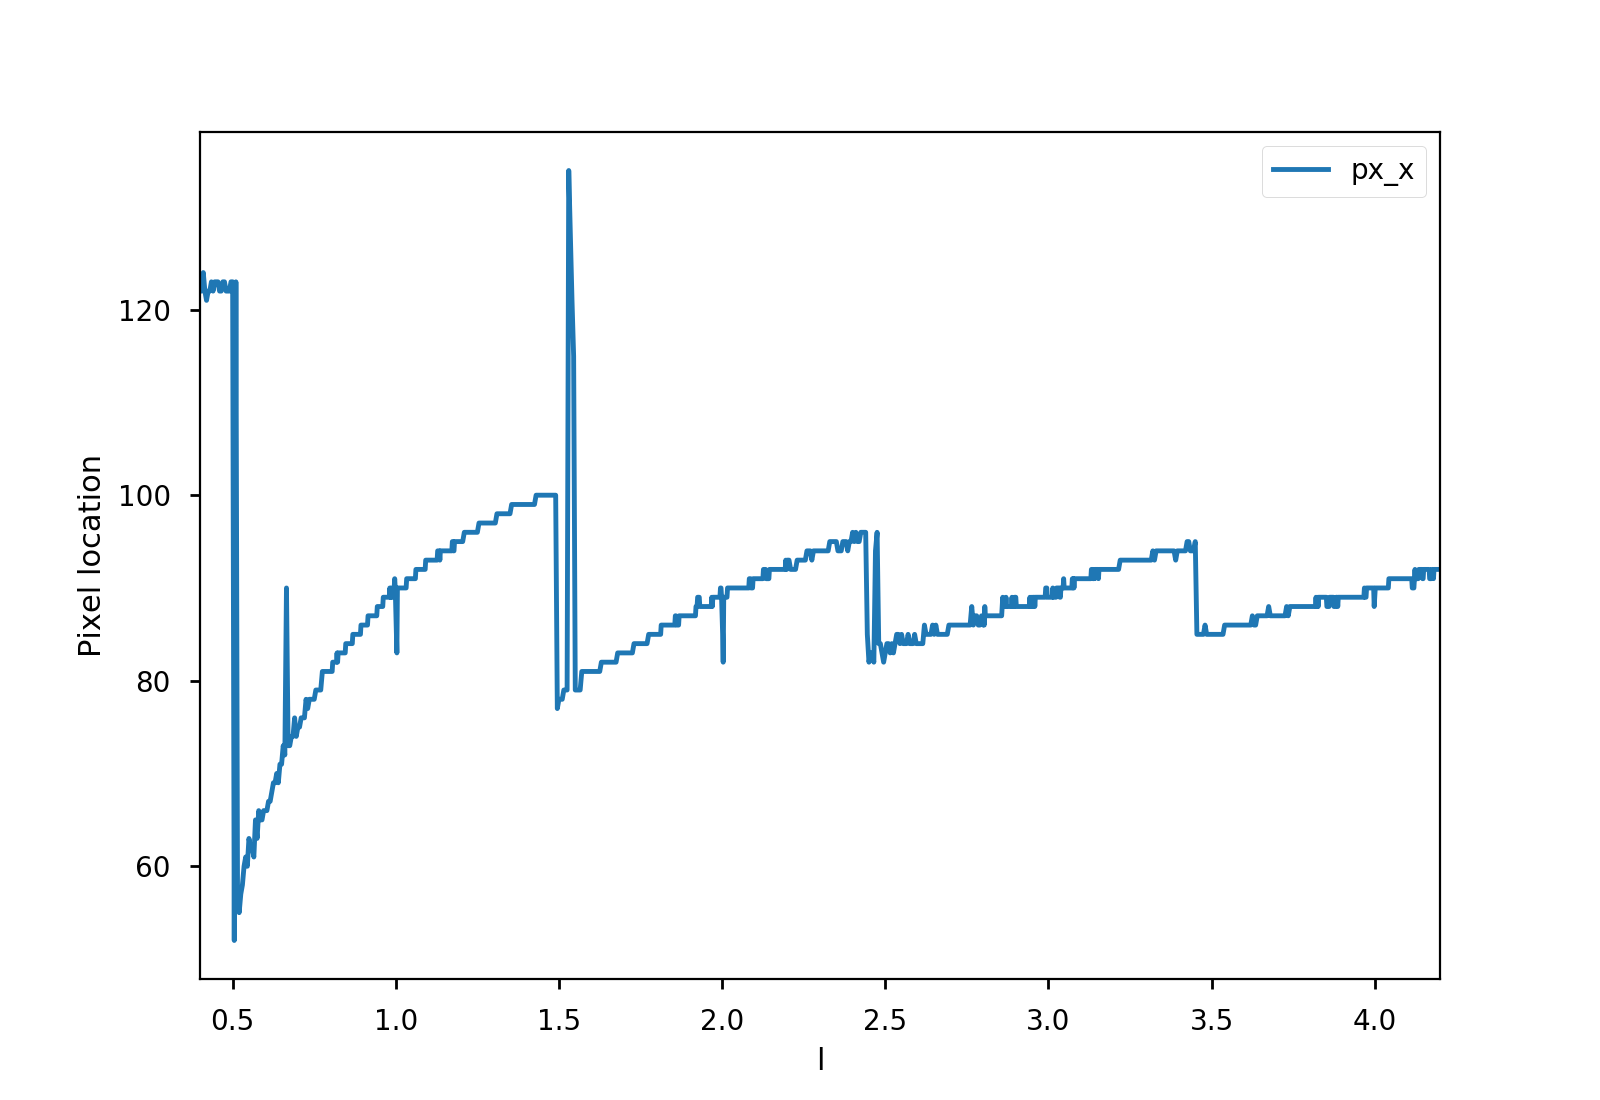

Text(0, 0.5, 'Pixel location')

In [24]:
ax = scan.plot(x='l', y='px_x')

ax.set_ylabel('Pixel location')

# Tracking central pixel

## Comparing tracking and no tracking

<IPython.core.display.Javascript object>


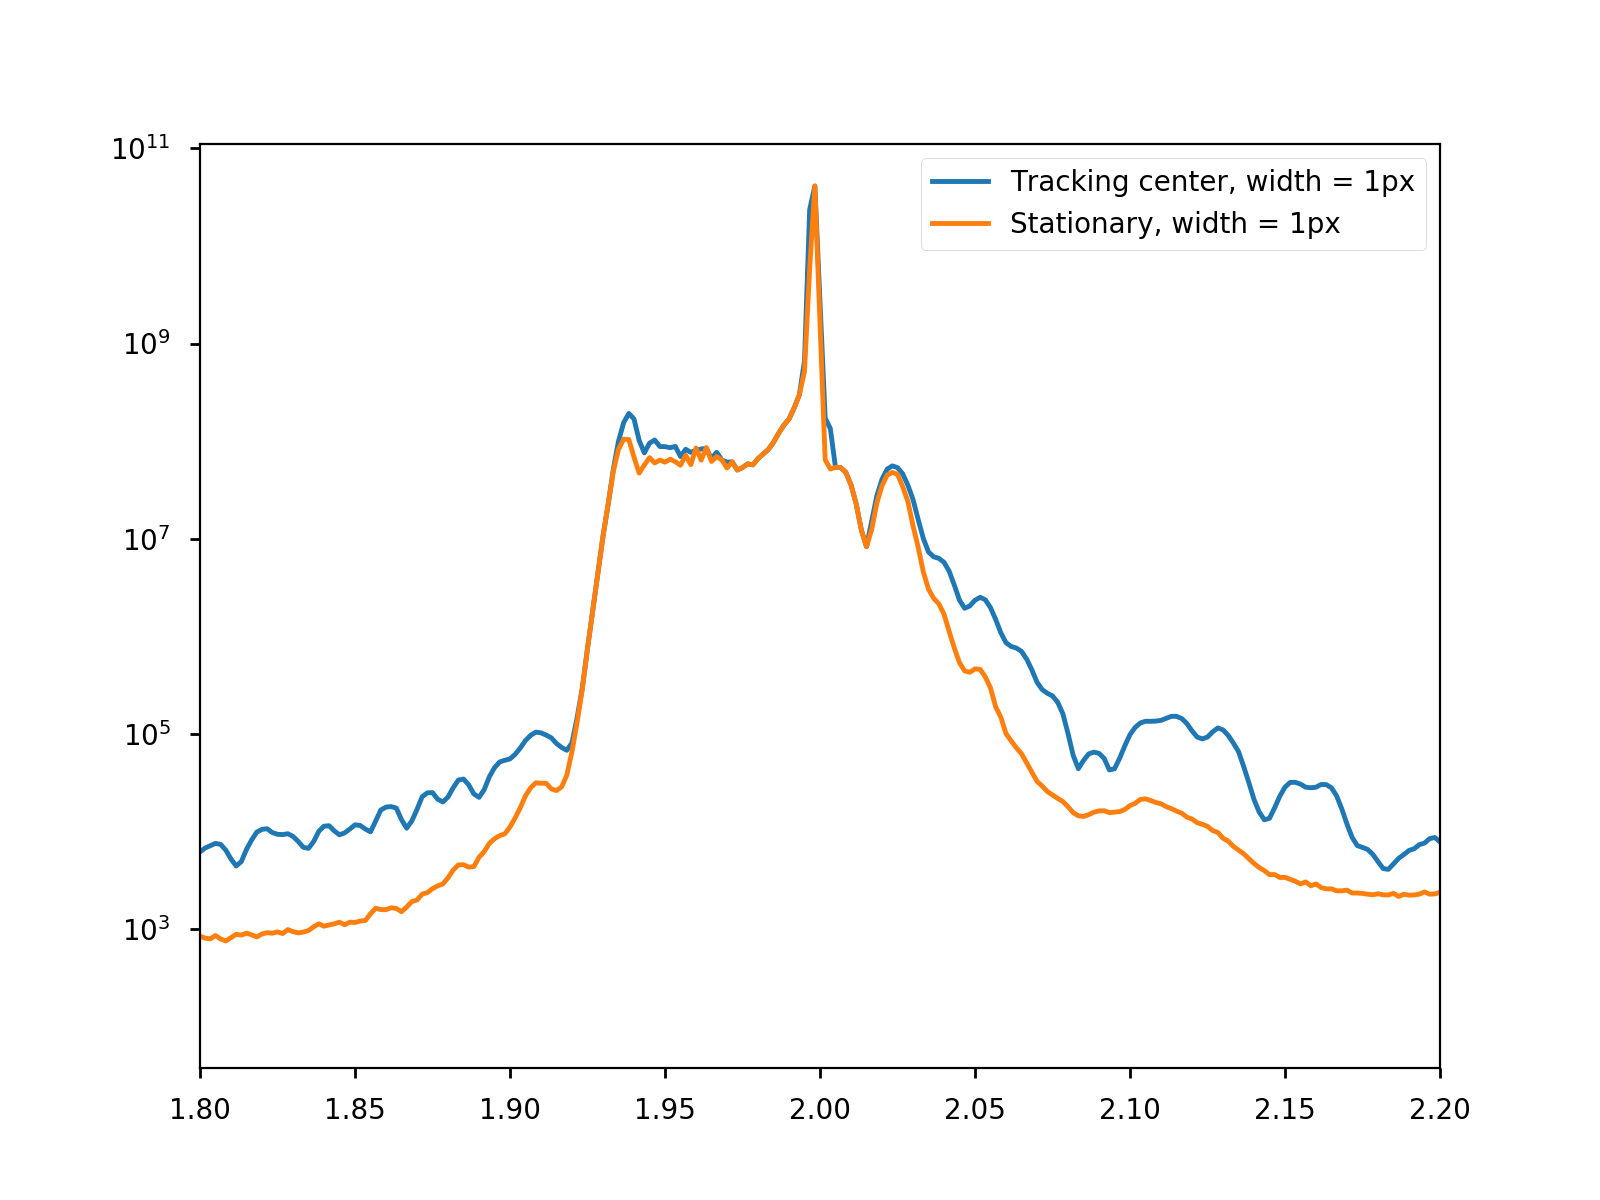

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

width = 1

ax.semilogy(scan['l'], sig_track[width], label='Tracking center, width = ' + str(width) +'px')
ax.semilogy(scan['l'], sig[width], label='Stationary, width = ' + str(width) +'px')


ax.set_xlim(left=1.8, right=2.2)

ax.legend()


## Many widths, tracking

<IPython.core.display.Javascript object>


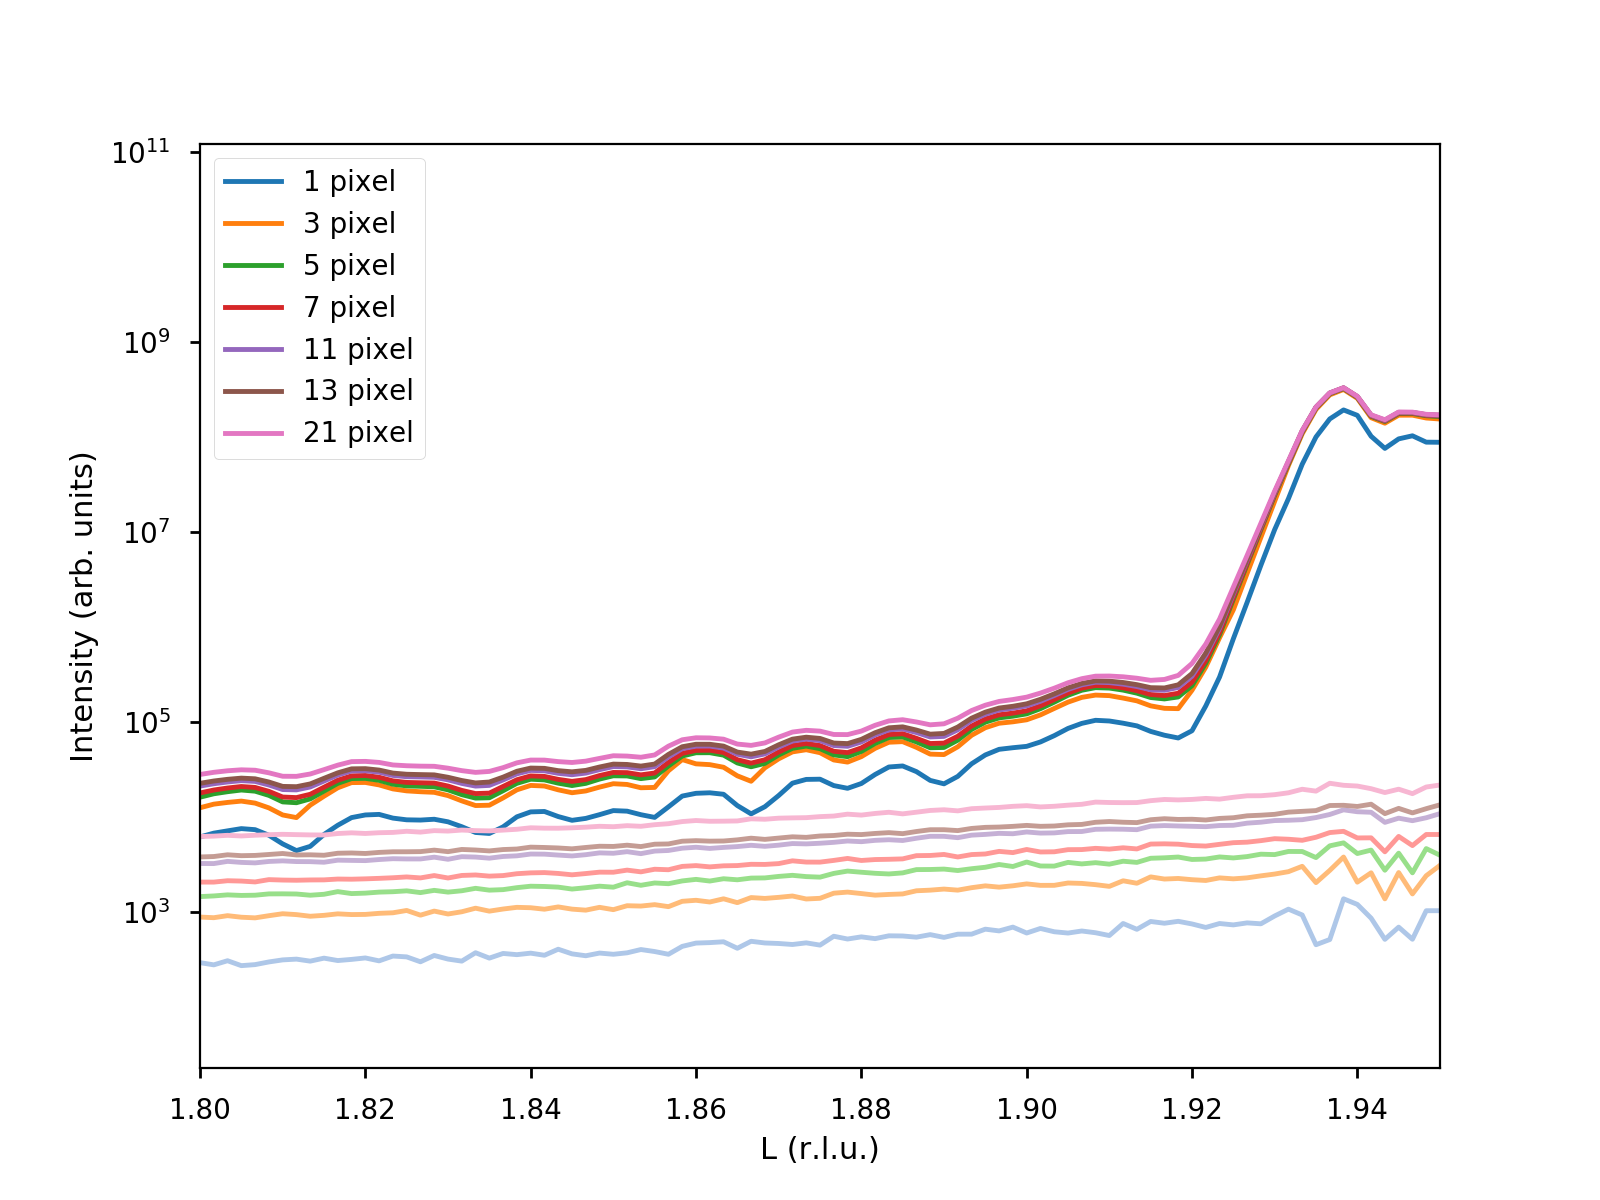

Text(0, 0.5, 'Intensity (arb. units)')

In [26]:
plt.style.use('seaborn-notebook')

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_prop_cycle(cycler(color=plt.get_cmap('tab20').colors))


for width in widths:
    ax.semilogy(scan['l'], sig_track[width], label=str(width) + ' pixel') 
    ax.semilogy(scan['l'], back_track[width], label='_nolegend_')
    
ax.set_xlim(left=1.8, right=1.95)

ax.legend()

ax.set_xlabel('L (r.l.u.)')
ax.set_ylabel('Intensity (arb. units)')

## sig - background, tracking

<IPython.core.display.Javascript object>


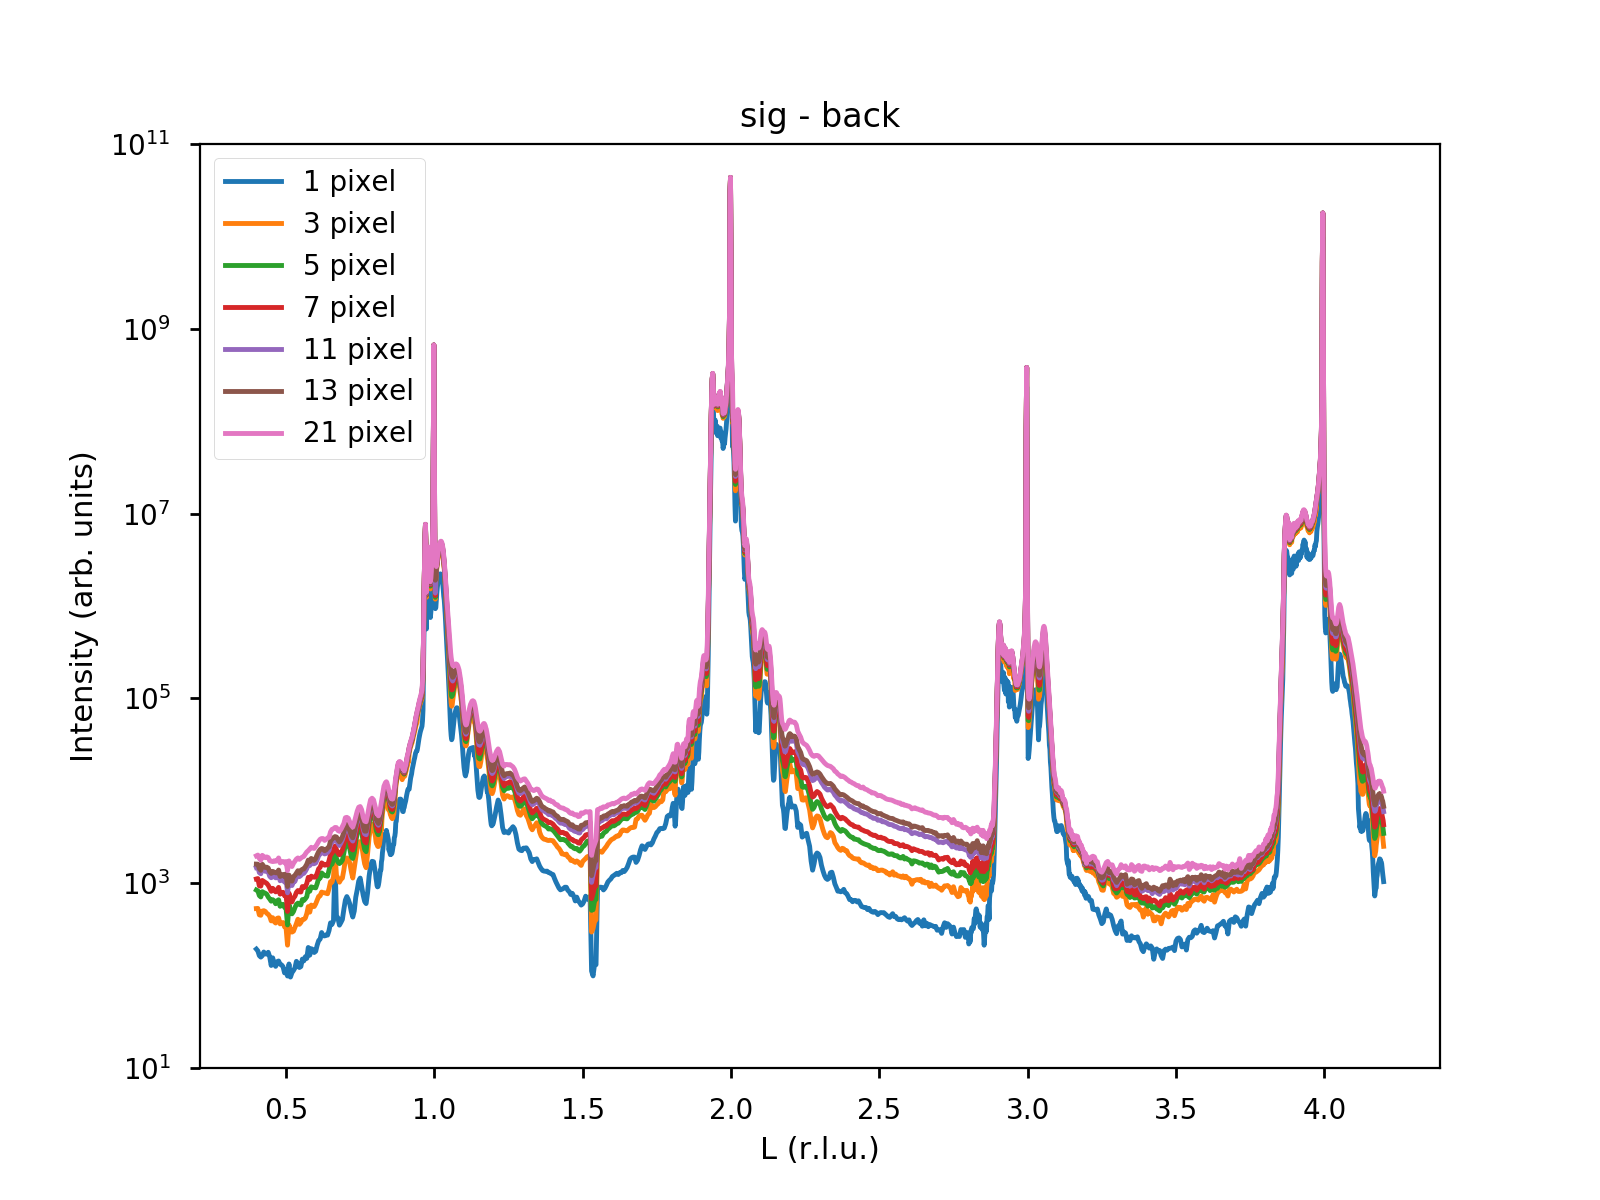

Text(0.5, 1.0, 'sig - back')

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
for width in widths:
    ax.semilogy(scan['l'], sig_track[width] - back_track[width], label=str(width) + ' pixel')
    
ax.set_xlabel('L (r.l.u.)')
ax.set_ylabel('Intensity (arb. units)')

#ax.set_xlim(left=1.8, right=2.2)
ax.legend()

ax.set_ylim(bottom=1e1, top=1e11)

ax.set_title('sig - back')